/home/ivananokhin/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Value iteration converged after 8 iterations.


/home/ivananokhin/tabular_rl/utils/helper_functions_multitask.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])
/home/ivananokhin/tabular_rl/utils/helper_functions.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[r, c]])


goal_reached 5
goal_reached 4
goal_reached 2
goal_reached 1
goal_reached 6
goal_reached 5
goal_reached 3
goal_reached 2
goal_reached 7
goal_reached 6
goal_reached 5
goal_reached 4
goal_reached 3


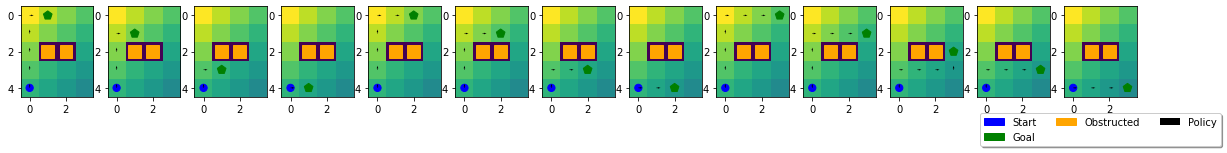

In [1]:
import sys
sys.path.append("..")
import numpy as np
from env.grid_world_multitask import GridWorld
from algorithms.dynamic_programming_multitask import value_iteration
from utils.plots_multitask import plot_gridworld, plot_gridworld_subtasks
import copy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

###########################################################
#          Run value iteration on a grid world            #
###########################################################

# specify world parameters
num_cols = 4
num_rows = 5
all_states = [ [i, j] for j in range(num_cols) for i in range(num_rows)]
obstructions = [[2,1],[2,2]]
goal_states = np.array([ el for el in all_states if el not in obstructions])
obstructions = np.array(obstructions)
start_states_plot = goal_states[4:5]
goal_states_plot = goal_states[5:]

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=goal_states,
               goal_states=goal_states)
gw.add_obstructions(
                    obstructed_states=obstructions,
                    # bad_states=bad_states,
                    # restart_states=restart_states
                    )
gw.add_rewards(
               step_reward=0,
               goal_reward=1,
               bad_state_reward=0,
               restart_state_reward=0)
gw.add_transition_probability(p_good_transition=1.,
                              bias=0.)
gw.add_discount(discount=0.9)
model = gw.create_gridworld()


# solve with value iteration
value_function, policy = value_iteration(model, maxiter=100)


# plot the results
path = "../doc/imgs/value_iteration.png"
plot_gridworld(model, value_function=value_function, policy=policy,
               # title="Value iteration",
               path=path,
               start_states=start_states_plot, goal_states=goal_states_plot)


In [2]:
value_function = value_function[:, :, 0]

In [3]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))

    # plot the results
    path = "../doc/imgs/value_iteration.png"
    plot_gridworld(model, value_function=val_hat_, policy=pi_hat,
                   # title="Value iteration",
                   path=path,
                   start_states=start_states_plot, goal_states=goal_states_plot)

(21, 21)

In [4]:
from utils.helper_functions import row_col_to_seq, seq_to_col_row

In [7]:
device='cuda'

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [9]:
# mean, std = 0., 1.
mean, std = np.mean(goal_states, axis=0), np.std(goal_states, axis=0)

In [10]:
from dataset import ValueDataset

In [11]:
# Prepare dataset
dataset = ValueDataset(value_function,
                       states=goal_states,
                       model=model, 
                       mean=mean, std=std
                      )
trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

In [12]:
from modules import ValueApproximator

In [13]:
# Initialize the MLP
mlp = ValueApproximator(states=goal_states, 
         mean=mean, std=std,
         device=device,
         value_function=value_function
        ).to(device)

# Define the loss function and optimizer
# loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3)

In [ ]:
# Run the training loop
for epoch in range(0, 1000): # 5 epochs at maximum
    # Print epoch
#     print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        s, g, s_idx, g_idx  = data
        s, g, s_idx, g_idx = s.float().to(device), g.float().to(device), s_idx.long().to(device), g_idx.long().to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        y, v, loss = mlp(s, g, s_idx, g_idx)       

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    if epoch % 10 == 0:
        print('Loss: %.3f' % (current_loss ))
        
    current_loss = 0.0

# Process is complete.
print('Training process has finished.')

In [22]:
predict = []
for x in X:
    s = torch.tensor(x[:2]).float().to(device)[None]
    g = torch.tensor(x[2:]).float().to(device)[None]
    s_idx = row_col_to_seq(s, model.num_cols).long()
    g_idx = row_col_to_seq(g, model.num_cols).long()
    s = (s - torch.tensor(mean).float().to(device)) / torch.tensor(std).float().to(device)
    g = (g - torch.tensor(mean).float().to(device)) / torch.tensor(std).float().to(device)
    m, m_idx = mlp.sample_middle_state(s, g)
    v, _, _ = mlp(s, g, s_idx, g_idx)
#     print('m_idx', m_idx)
    
    predict.append(v.detach().cpu().numpy()[:, 0])

predict = np.array(predict)[:, 0]
    
    

In [24]:
# predict

In [25]:
goal_states[8:9]

array([[4, 1]])

In [29]:
start_states_plot = goal_states[2:3] #goal_states[8:9]
goal_states_plot = goal_states #goal_states[:6]

start_state_sub = np.tile(start_states_plot, (len(goal_states_plot), 1))
goal_states_sub = goal_states_plot
subgoal_states_sub = []


for s, g in zip(start_state_sub, goal_states_sub):
    s = torch.tensor(x[:2]).float().to(device)[None]
    g = torch.tensor(x[2:]).float().to(device)[None]
    s_idx = row_col_to_seq(s, model.num_cols).long()
    g_idx = row_col_to_seq(g, model.num_cols).long()
    s = (s - torch.tensor(mean).float().to(device)) / torch.tensor(std).float().to(device)
    g = (g - torch.tensor(mean).float().to(device)) / torch.tensor(std).float().to(device)
    _, m_idx = mlp.sample_middle_state(s, g)
    if m_idx==g_idx or m_idx==s_idx:
        subgoal_states_sub.append([None])
    else:
        subgoal_states_sub.append(m_idx)
        
print(start_state_sub.shape, goal_states_sub.shape, len(subgoal_states_sub))


(18, 2) (18, 2) 18


In [30]:
subgoal_states_sub

[tensor([-1], device='cuda:0'),
 tensor([-4], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([-2], device='cuda:0'),
 tensor([-1], device='cuda:0'),
 tensor([-1], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor([-3], device='cuda:0'),
 tensor([-4], device='cuda:0'),
 tensor([-4], device='cuda:0'),
 tensor([-1], device='cuda:0'),
 tensor([1], device='cuda:0'),
 tensor([-4], device='cuda:0'),
 tensor([2], device='cuda:0'),
 tensor([-4], device='cuda:0'),
 tensor([6], device='cuda:0'),
 tensor([-2], device='cuda:0')]

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,20)

In [32]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))
    
    return pi_hat

IndexError: too many indices for tensor of dimension 1

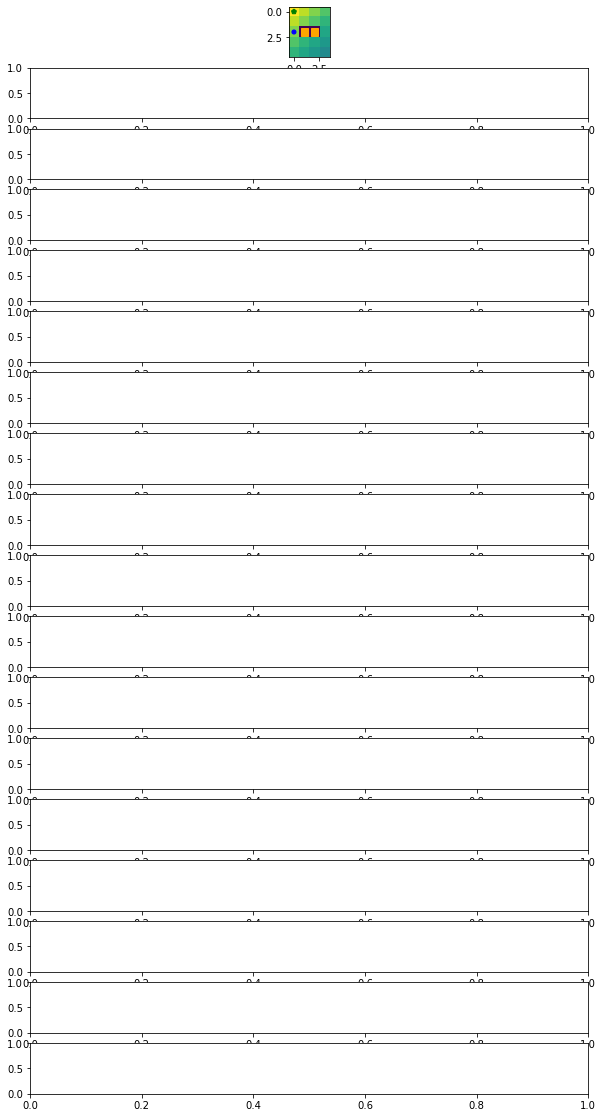

In [33]:
pi_hat = find_plot_pi_hat(predict, model, index)
plot_gridworld_subtasks(model, value_function=value_function, policy=pi_hat, path=path,
                       start_states=start_state_sub, goal_states=goal_states_sub, subgoal_states=subgoal_states_sub)